In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [58]:
data = pd.read_csv('/Users/suprita/supriML/kaggle_comp_titanic/titanic_data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
data.describe()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


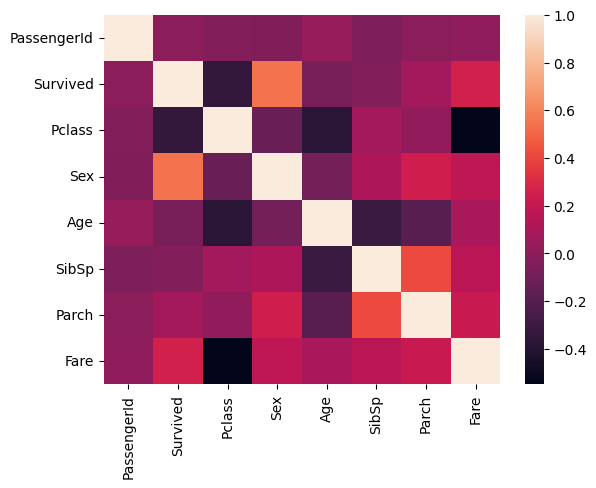

In [46]:
# find correlations to survival
import seaborn as sns
sns.heatmap(data.corr())
plt.show()

In [63]:
# strong correlations: pclass, fare, sex so we want equal nums of this in train and test

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data, data[['Survived', 'Pclass', 'Sex']]):
    train = data.loc[train_indices]
    test = data.loc[test_indices]

<Axes: >

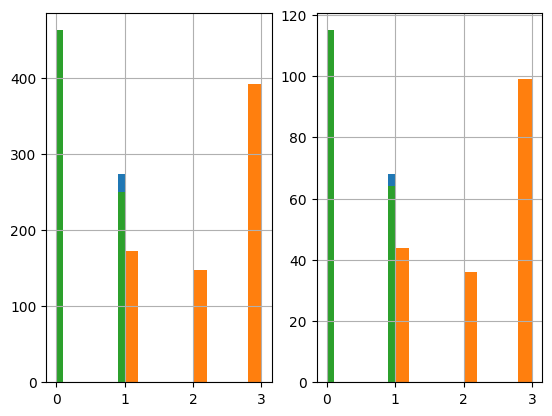

In [53]:
# should be identical
plt.subplot(1, 2, 1)
train['Survived'].hist()
train['Pclass'].hist()
train['Sex'].hist()

plt.subplot(1, 2, 2)
test['Survived'].hist()
test['Pclass'].hist()
test['Sex'].hist()

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 869 to 193
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    int64  
 4   Age          574 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Fare         712 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 50.1 KB


In [78]:
# missing age values, going to impute this data

from  sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

#fit transform
class age_imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='mean')
        self.imputer.fit(X[['Age']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

In [93]:
class onehot(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None): # gonna return the baseestimator
        return self
    def transform(self, x):
        gender_map = {'male': 0, 'female': 1}
        x['Sex'] = x['Sex'].map(gender_map)
        return x

In [84]:
# dropping useless features
class dropper(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None): # gonna return the baseestimator
        return self
    def transform(self, x):
        return x.drop(['PassengerId', 'Embarked', 'Name', 'Ticket', 'Cabin', 'N'], axis=1, errors='ignore')

In [83]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [94]:
# build data pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('imputer', age_imputer()),
                     ('dropper', dropper())
                     ('onehot', onehot())])

train = pipeline.fit_transform(train)
train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 256 to 363
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    int64  
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 60.7 KB


In [95]:
from sklearn.preprocessing import StandardScaler

x = train.drop(['Survived'], axis=1)
y = train['Survived']
# scale data
scaler = StandardScaler()
x_data = scaler.fit_transform(x)
y_data = y.to_numpy()

In [97]:
# train, using random forest classifier
# grid search for finding best parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
params = {
    'n_estimators': [10, 100, 200, 500],
     'max_depth': [None, 5, 10],
     'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(clf, params, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(x_data, y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [99]:
test = pipeline.fit_transform(test)
test

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
866,1,2,1,27.000000,1,0,13.8583
461,0,3,0,34.000000,0,0,8.0500
164,0,3,0,1.000000,4,1,39.6875
677,1,3,1,18.000000,0,0,9.8417
666,0,2,0,25.000000,0,0,13.0000
...,...,...,...,...,...,...,...
485,0,3,1,30.049137,3,1,25.4667
792,0,3,1,30.049137,8,2,69.5500
55,1,1,0,30.049137,0,0,35.5000
762,1,3,0,20.000000,0,0,7.2292


In [100]:
x_test = test.drop(['Survived'], axis=1)
y_test = test['Survived']

x_test_data = scaler.fit_transform(x_test)
y_test_data = y_test.to_numpy()

In [101]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=10)

In [102]:
final_clf.score(x_test_data, y_test_data)

0.8212290502793296

In [104]:
data = pipeline.fit_transform(data)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.000000,1,0,7.2500
1,1,1,1,38.000000,1,0,71.2833
2,1,3,1,26.000000,0,0,7.9250
3,1,1,1,35.000000,1,0,53.1000
4,0,3,0,35.000000,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000
887,1,1,1,19.000000,0,0,30.0000
888,0,3,1,29.699118,1,2,23.4500
889,1,1,0,26.000000,0,0,30.0000


In [105]:
x_final = data.drop(['Survived'], axis=1)
y_final = data['Survived']

x_final = scaler.fit_transform(x_final)
y_final = y_final.to_numpy()

In [106]:
clf = RandomForestClassifier()
params = {
    'n_estimators': [10, 100, 200, 500],
     'max_depth': [None, 5, 10],
     'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(clf, params, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(x_final, y_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [107]:
# make final predictions with test data
prod_test = pd.read_csv('/Users/suprita/supriML/kaggle_comp_titanic/titanic_data/test.csv')
prod_test = pipeline.fit_transform(prod_test)
prod_test

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,34.50000,0,0,7.8292
1,3,1,47.00000,1,0,7.0000
2,2,0,62.00000,0,0,9.6875
3,3,0,27.00000,0,0,8.6625
4,3,1,22.00000,1,1,12.2875
...,...,...,...,...,...,...
413,3,0,30.27259,0,0,8.0500
414,1,1,39.00000,0,0,108.9000
415,3,0,38.50000,0,0,7.2500
416,3,0,30.27259,0,0,8.0500


In [108]:
prod_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    417 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [109]:
prod_test = prod_test.fillna(method='ffill')
x_prod = scaler.fit_transform(prod_test)
prod_clf = grid_search.best_estimator_
prod_clf

/var/folders/vk/dz3124891t57s2drmdtdgwgm0000gn/T/ipykernel_4187/2040837480.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prod_test = prod_test.fillna(method='ffill')


RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=10)

In [110]:
predictions = prod_clf.predict(x_prod)

In [112]:
og_test_df = pd.read_csv('/Users/suprita/supriML/kaggle_comp_titanic/titanic_data/test.csv')
submission = pd.DataFrame(og_test_df['PassengerId'])
submission['Survived'] = predictions
submission.to_csv('/Users/suprita/supriML/kaggle_comp_titanic/predictions.csv', index=False)

In [113]:
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,0
9,901,0
